* 本例展示如何在alpha-mind中使用机器学习模型

* 请在环境变量中设置`DB_URI`指向数据库

In [1]:
%matplotlib inline

import os
import datetime as dt
import numpy as np
import pandas as pd
from alphamind.api import *
from PyFin.api import *

## 数据配置
------------

In [2]:
freq = '20b'
universe = Universe('zz800')
batch = 8
neutralized_risk = industry_styles
risk_model = 'short'
pre_process = [winsorize_normal, standardize]
post_process = [standardize]
warm_start = 0
data_source = os.environ['DB_URI']
horizon = map_freq(freq)

engine = SqlEngine(data_source)

我们使用当期的`[ROE, EPS, ETOP]`因子，来尝试预测未来大概一个月以后的收益。

* 训练的股票池为`zz800`;；
* 因子都经过中性化以及标准化等预处理；
* 对于线性模型，我们以20个工作日为一个时间间隔，用过去8期的数据作为训练用特征。

In [3]:
fit_intercept = True
features = ['ROE', 'EPS', 'ETOP']

data_meta = DataMeta(freq=freq,
                     universe=universe,
                     batch=batch,
                     neutralized_risk=neutralized_risk,
                     risk_model=risk_model,
                     pre_process=pre_process,
                     post_process=post_process,
                     warm_start=warm_start,
                     data_source=data_source)

alpha_model = LinearRegression(features=features, fit_intercept=True)
composer = Composer(alpha_model=alpha_model, data_meta=data_meta)

start_date = '2011-01-01'
end_date = '2019-01-15'

## 模型预测
-----------

In [4]:
ref_date = '2017-01-31'
ref_date = adjustDateByCalendar('china.sse', ref_date).strftime('%Y-%m-%d')
model, x, y = composer.train(ref_date)

In [5]:
print("Testing IC: {0:.4f}".format(composer.ic(ref_date=ref_date)[0]))

Testing IC: -0.0580


## 模型对比 （线性回归模型 v.s. Naive - 常数线性模型）
------------------

In [6]:
const_model = ConstLinearModel(features=features, weights={f: 1. for f in features})
regression_model = LinearRegression(features=features, fit_intercept=fit_intercept)

const_composer = Composer(alpha_model=const_model, data_meta=data_meta)
regression_composer = Composer(alpha_model=regression_model, data_meta=data_meta)

In [7]:
const_composer.train(ref_date)
regression_composer.train(ref_date)
pass

In [8]:
print("\nConst. Testing IC: {0:.4f}".format(const_composer.ic(ref_date=ref_date)[0]))
print("Regression Testing IC: {0:.4f}".format(regression_composer.ic(ref_date=ref_date)[0]))


Const. Testing IC: -0.0413
Regression Testing IC: -0.0580


## 模型时间序列
-------------------------

通过比较在测试集的结果，我们观察如下两个模型的表现：

* Naive Model：简单的使用因子上期值作为当期值的预测；
* 线性回归模型：利用过去四期的因子值回归后得到模型，然后用这个模型预测当期值；

In [9]:
model_dates = makeSchedule(start_date, end_date, freq, 'china.sse')
model_dates = [d.strftime("%Y-%m-%d") for d in model_dates]

model_df = pd.DataFrame(columns=['naive', 'regress', 'naive ic.', 'regress ic.'])

test_data = {}

for ref_date in model_dates:
    regression_composer.train(ref_date)
    const_composer.train(ref_date)
    
    model_df.loc[ref_date, 'naive'] = const_composer[ref_date]
    model_df.loc[ref_date, 'regress'] = regression_composer[ref_date]
    model_df.loc[ref_date, 'naive ic.'], x, y  = const_composer.ic(ref_date=ref_date)
    model_df.loc[ref_date, 'regress ic.'], _, _ = regression_composer.ic(ref_date=ref_date, x=x, y=y)
    
    test_data[ref_date] = (x, y)

    print("\n{1} Const. Testing IC: {0:.4f}".format(model_df.loc[ref_date, 'naive ic.'], ref_date))
    print("{1} Regression Testing IC: {0:.4f}".format( model_df.loc[ref_date, 'regress ic.'], ref_date))


2011-01-04 Const. Testing IC: -0.0269
2011-01-04 Regression Testing IC: 0.2138

2011-02-01 Const. Testing IC: -0.0767
2011-02-01 Regression Testing IC: -0.0038

2011-03-08 Const. Testing IC: -0.1069
2011-03-08 Regression Testing IC: 0.1013

2011-04-07 Const. Testing IC: -0.0382
2011-04-07 Regression Testing IC: 0.1166

2011-05-06 Const. Testing IC: 0.1219
2011-05-06 Regression Testing IC: 0.0674

2011-06-03 Const. Testing IC: 0.1503
2011-06-03 Regression Testing IC: 0.0412

2011-07-04 Const. Testing IC: -0.0160
2011-07-04 Regression Testing IC: -0.1363

2011-08-01 Const. Testing IC: 0.0945
2011-08-01 Regression Testing IC: -0.0527

2011-08-29 Const. Testing IC: -0.1122
2011-08-29 Regression Testing IC: 0.1061

2011-09-27 Const. Testing IC: 0.0605
2011-09-27 Regression Testing IC: 0.1205

2011-11-01 Const. Testing IC: -0.0664
2011-11-01 Regression Testing IC: 0.0691

2011-11-29 Const. Testing IC: 0.3047
2011-11-29 Regression Testing IC: -0.1484

2011-12-27 Const. Testing IC: 0.1569
201

In [10]:
model_df[['naive ic.', 'regress ic.']].agg(['mean', 'std'])

,naive ic.,regress ic.
mean,0.032286,0.027784
std,0.116897,0.099669


在这个例子中，线性回归模型的IC值略微高于Naive模型。

## 回测（ simple long short strategy）
--------------------------

In [11]:
industry_name = 'sw_adj'
industry_level = 1

industry_names = industry_list(industry_name, industry_level)
industry_total = engine.fetch_industry_matrix_range(universe, dates=model_dates, category=industry_name, level=industry_level)

dx_return_data = engine.fetch_dx_return_range(universe=universe,
                                              dates=model_dates,
                                              horizon=horizon)

In [12]:
dx_return_data.head()

,trade_date,code,dx
39139,2011-01-04,1,-0.036793
39188,2011-01-04,2,-0.072883
98,2011-01-04,5,-0.066037
104,2011-01-04,6,-0.012519
39309,2011-01-04,9,0.059210


In [14]:
rets1 = []
rets2 = []

for i, ref_date in enumerate(model_dates):
    py_ref_date = dt.datetime.strptime(ref_date, '%Y-%m-%d')
    industry_matrix = industry_total[industry_total.trade_date == ref_date]
    dx_returns = dx_return_data[dx_return_data.trade_date == py_ref_date][['code', 'dx']]
    
    res = pd.merge(dx_returns, industry_matrix, on=['code']).dropna()
    codes = res.code.values.tolist()
    
    alpha_logger.info('{0} full re-balance: {1}'.format(ref_date, len(codes)))
    
    x_test, _ = test_data[ref_date]
    
    ## naive model
    
    raw_predict1 = const_composer.predict(ref_date, x=x_test)[0].reindex(codes)
    er1 = raw_predict1.fillna(raw_predict1.median()).values
    
    target_pos1, _ = er_portfolio_analysis(er1,
                                           res.industry_name.values,
                                           None,
                                           None,
                                           False,
                                           None,
                                           method='ls')
        
    target_pos1['code'] = codes
    result1 = pd.merge(target_pos1, dx_returns, on=['code'])
    ret1 = result1.weight.values @ (np.exp(result1.dx.values) - 1.)
    rets1.append(np.log(1. + ret1))

    ## regression model
    
    raw_predict2 = regression_composer.predict(ref_date, x=x_test)[0].reindex(codes)
    er2 = raw_predict2.fillna(raw_predict2.median()).values
    
    target_pos2, _ = er_portfolio_analysis(er2,
                                           res.industry_name.values,
                                           None,
                                           None,
                                           False,
                                           None,
                                           method='ls')
    
    target_pos2['code'] = codes
    result2 = pd.merge(target_pos2, dx_returns, on=['code'])
    ret2 = result2.weight.values @ (np.exp(result2.dx.values) - 1.)
    rets2.append(np.log(1. + ret2))
    
    alpha_logger.info('{0} is finished'.format(ref_date))

2019-02-10 00:07:59,902 - ALPHA_MIND - INFO - 2011-01-04 full re-balance: 799
2019-02-10 00:07:59,927 - ALPHA_MIND - INFO - 2011-01-04 is finished
2019-02-10 00:07:59,937 - ALPHA_MIND - INFO - 2011-02-01 full re-balance: 798
2019-02-10 00:07:59,953 - ALPHA_MIND - INFO - 2011-02-01 is finished
2019-02-10 00:07:59,963 - ALPHA_MIND - INFO - 2011-03-08 full re-balance: 798
2019-02-10 00:07:59,979 - ALPHA_MIND - INFO - 2011-03-08 is finished
2019-02-10 00:07:59,990 - ALPHA_MIND - INFO - 2011-04-07 full re-balance: 798
2019-02-10 00:08:00,007 - ALPHA_MIND - INFO - 2011-04-07 is finished
2019-02-10 00:08:00,019 - ALPHA_MIND - INFO - 2011-05-06 full re-balance: 798
2019-02-10 00:08:00,037 - ALPHA_MIND - INFO - 2011-05-06 is finished
2019-02-10 00:08:00,047 - ALPHA_MIND - INFO - 2011-06-03 full re-balance: 798
2019-02-10 00:08:00,063 - ALPHA_MIND - INFO - 2011-06-03 is finished
2019-02-10 00:08:00,074 - ALPHA_MIND - INFO - 2011-07-04 full re-balance: 798
2019-02-10 00:08:00,090 - ALPHA_MIND - I

2019-02-10 00:08:01,496 - ALPHA_MIND - INFO - 2015-08-13 full re-balance: 800
2019-02-10 00:08:01,513 - ALPHA_MIND - INFO - 2015-08-13 is finished
2019-02-10 00:08:01,524 - ALPHA_MIND - INFO - 2015-09-14 full re-balance: 800
2019-02-10 00:08:01,540 - ALPHA_MIND - INFO - 2015-09-14 is finished
2019-02-10 00:08:01,549 - ALPHA_MIND - INFO - 2015-10-19 full re-balance: 800
2019-02-10 00:08:01,563 - ALPHA_MIND - INFO - 2015-10-19 is finished
2019-02-10 00:08:01,575 - ALPHA_MIND - INFO - 2015-11-16 full re-balance: 800
2019-02-10 00:08:01,591 - ALPHA_MIND - INFO - 2015-11-16 is finished
2019-02-10 00:08:01,601 - ALPHA_MIND - INFO - 2015-12-14 full re-balance: 800
2019-02-10 00:08:01,617 - ALPHA_MIND - INFO - 2015-12-14 is finished
2019-02-10 00:08:01,627 - ALPHA_MIND - INFO - 2016-01-12 full re-balance: 800
2019-02-10 00:08:01,642 - ALPHA_MIND - INFO - 2016-01-12 is finished
2019-02-10 00:08:01,654 - ALPHA_MIND - INFO - 2016-02-16 full re-balance: 800
2019-02-10 00:08:01,669 - ALPHA_MIND - I

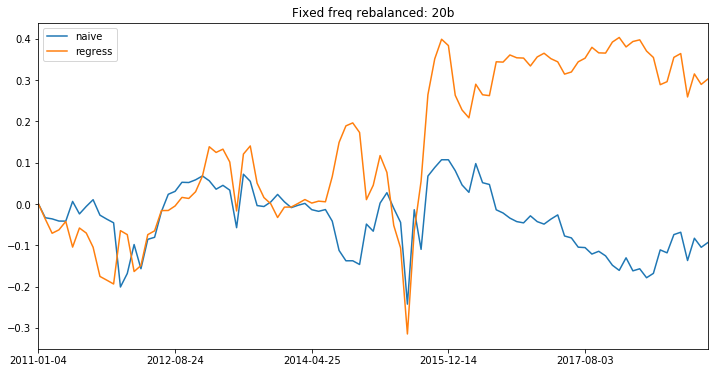

In [15]:
ret_df = pd.DataFrame({'naive': rets1, 'regress': rets2}, index=model_dates)
ret_df.loc[advanceDateByCalendar('china.sse', model_dates[-1], freq).strftime('%Y-%m-%d')] = 0.
ret_df = ret_df.shift(1)
ret_df.iloc[0] = 0.

ret_df[['naive', 'regress']].cumsum().plot(figsize=(12, 6),
                                             title='Fixed freq rebalanced: {0}'.format(freq))